# Networks Using Blocks (VGG)
:label:`sec_vgg`

While AlexNet offered empirical evidence that deep CNNs
can achieve good results, it did not provide a general template
to guide subsequent researchers in designing new networks.
In the following sections, we will introduce several heuristic concepts
commonly used to design deep networks.

Progress in this field mirrors that of VLSI (very large scale integration) 
in chip design
where engineers moved from placing transistors
to logical elements to logic blocks :cite:`Mead.1980`.
Similarly, the design of neural network architectures
has grown progressively more abstract,
with researchers moving from thinking in terms of
individual neurons to whole layers,
and now to blocks, repeating patterns of layers. A decade later, this has now
progressed to researchers using entire trained models to repurpose them for different, 
albeit related, tasks. Such large pretrained models are typically called 
*foundation models* :cite:`bommasani2021opportunities`. 

Back to network design. The idea of using blocks first emerged from the
Visual Geometry Group (VGG) at Oxford University,
in their eponymously-named *VGG* network :cite:`Simonyan.Zisserman.2014`.
It is easy to implement these repeated structures in code
with any modern deep learning framework by using loops and subroutines.

In [1]:
using Pkg; Pkg.activate("../../d2lai")
using d2lai
using Flux 
using CUDA, cuDNN

  Activating project at `/workspace/d2l-julia/d2lai`
[ Info: Precompiling d2lai [749b8817-cd67-416c-8a57-830ea19f3cc4] (cache misses: include_dependency fsize change (2))


## (**VGG Blocks**)
:label:`subsec_vgg-blocks`

The basic building block of CNNs
is a sequence of the following:
(i) a convolutional layer
with padding to maintain the resolution,
(ii) a nonlinearity such as a ReLU,
(iii) a pooling layer such
as max-pooling to reduce the resolution. One of the problems with 
this approach is that the spatial resolution decreases quite rapidly. In particular, 
this imposes a hard limit of $\log_2 d$ convolutional layers on the network before all 
dimensions ($d$) are used up. For instance, in the case of ImageNet, it would be impossible to have 
more than 8 convolutional layers in this way. 

The key idea of :citet:`Simonyan.Zisserman.2014` was to use *multiple* convolutions in between downsampling
via max-pooling in the form of a block. They were primarily interested in whether deep or 
wide networks perform better. For instance, the successive application of two $3 \times 3$ convolutions
touches the same pixels as a single $5 \times 5$ convolution does. At the same time, the latter uses approximately 
as many parameters ($25 \cdot c^2$) as three $3 \times 3$ convolutions do ($3 \cdot 9 \cdot c^2$). 
In a rather detailed analysis they showed that deep and narrow networks significantly outperform their shallow counterparts. This set deep learning on a quest for ever deeper networks with over 100 layers for typical applications.
Stacking $3 \times 3$ convolutions
has become a gold standard in later deep networks (a design decision only to be revisited recently by 
:citet:`liu2022convnet`). Consequently, fast implementations for small convolutions have become a staple on GPUs :cite:`lavin2016fast`. 

Back to VGG: a VGG block consists of a *sequence* of convolutions with $3\times3$ kernels with padding of 1 
(keeping height and width) followed by a $2 \times 2$ max-pooling layer with stride of 2
(halving height and width after each block).
In the code below, we define a function called `vgg_block`
to implement one VGG block.

The function below takes two arguments,
corresponding to the number of convolutional layers `num_convs`
and the number of output channels `num_channels`.


In [8]:
struct VGGBlock{N} <: AbstractModel 
    net::N
end

function VGGBlock(num_convs, in_channels, out_channels, conv_size = 3)
    layers = map(1:num_convs) do i 
        if i == 1
            return Conv((conv_size,conv_size), in_channels => out_channels, relu, pad = 1)
        else
            return Conv((conv_size,conv_size), out_channels => out_channels, relu, pad = 1)
        end
    end
    net = Chain(layers..., 
        MaxPool((2,2), stride = 2),
    )
    VGGBlock(net)
end

Flux.@layer VGGBlock 

(v::VGGBlock)(x) = v.net(x)

# [**VGG Network**]
:label:`subsec_vgg-network`

Like AlexNet and LeNet, 
the VGG Network can be partitioned into two parts:
the first consisting mostly of convolutional and pooling layers
and the second consisting of fully connected layers that are identical to those in AlexNet. 
The key difference is 
that the convolutional layers are grouped in nonlinear transformations that 
leave the dimensonality unchanged, followed by a resolution-reduction step, as 
depicted in :numref:`fig_vgg`. 

![From AlexNet to VGG. The key difference is that VGG consists of blocks of layers, whereas AlexNet's layers are all designed individually.](../img/vgg.svg)
:width:`400px`
:label:`fig_vgg`

The convolutional part of the network connects several VGG blocks from :numref:`fig_vgg` (also defined in the `vgg_block` function)
in succession. This grouping of convolutions is a pattern that has 
remained almost unchanged over the past decade, although the specific choice of 
operations has undergone considerable modifications. 
The variable `arch` consists of a list of tuples (one per block),
where each contains two values: the number of convolutional layers
and the number of output channels,
which are precisely the arguments required to call
the `vgg_block` function. As such, VGG defines a *family* of networks rather than just 
a specific manifestation. To build a specific network we simply iterate over `arch` to compose the blocks.


In [3]:
struct VGGNet{N} <: AbstractClassifier 
    net::N 
end

function VGGNet(arch::Tuple, num_classes = 10)
    out_channels = getindex.(arch, 2)
    in_channels = (1, out_channels[1:end-1]...)
    num_convs = getindex.(arch, 1)
    blocks = map(num_convs, out_channels, in_channels) do n_conv, out_ch, in_ch
        VGGBlock(n_conv, in_ch, out_ch)
    end
    net = Flux.@autosize (224, 224, 1, 1) Chain(
        blocks...,
        Flux.flatten,
        Dense(_ => 4096, relu),
        Dropout(0.5),
        Dense(4096 => 4096, relu),
        Dropout(0.5),
        Dense(4096 => num_classes),
        softmax,
    )
    VGGNet(net)
end

Flux.@layer VGGNet

(vnet::VGGNet)(x) = vnet.net(x)


The original VGG network had five convolutional blocks, among which the first two have one convolutional layer each and the latter three contain two convolutional layers each. The first block has 64 output channels and each subsequent block doubles the number of output channels, until that number reaches 512. Since this network uses eight convolutional layers and three fully connected layers, it is often called VGG-11.



In [4]:
VGGNet(((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)))

VGGNet(
  Chain(
    VGGBlock(
      Chain(
        Conv((3, 3), 1 => 64, relu, pad=1),  # 640 parameters
        MaxPool((2, 2)),
      ),
    ),
    VGGBlock(
      Chain(
        Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
        MaxPool((2, 2)),
      ),
    ),
    VGGBlock(
      Chain(
        Conv((3, 3), 128 => 256, relu, pad=1),  # 295_168 parameters
        Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 parameters
        MaxPool((2, 2)),
      ),
    ),
    VGGBlock(
      Chain(
        Conv((3, 3), 256 => 512, relu, pad=1),  # 1_180_160 parameters
        Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters
        MaxPool((2, 2)),
      ),
    ),
    VGGBlock(
      Chain(
        Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters
        Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters
        MaxPool((2, 2)),
      ),
    ),
    Flux.flatten,
    Dense(25088 => 4096, relu),         # 102_764_544 parameters
    Dropo

As you can see, we halve height and width at each block, finally reaching a height and width of 7 before flattening the representations for processing by the fully connected part of the network. Simonyan and Zisserman (2014) described several other variants of VGG. In fact, it has become the norm to propose families of networks with different speed–accuracy trade-off when introducing a new architecture.


## Training

**Since VGG-11 is computationally more demanding than AlexNet
we construct a network with a smaller number of channels.**
This is more than sufficient for training on Fashion-MNIST.
The **model training** process is similar to that of AlexNet in :numref:`sec_alexnet`. 
Again observe the close match between validation and training loss, 
suggesting only a small amount of overfitting.


[ Info: Train Loss: 0.48188314, Val Loss: 0.3698047, Val Acc: 0.875
[ Info: Train Loss: 0.5084389, Val Loss: 0.25148895, Val Acc: 0.875
[ Info: Train Loss: 0.2939905, Val Loss: 0.26616976, Val Acc: 0.875
[ Info: Train Loss: 0.3377501, Val Loss: 0.21927431, Val Acc: 0.875
[ Info: Train Loss: 0.22468491, Val Loss: 0.18230689, Val Acc: 0.9375
[ Info: Train Loss: 0.34149575, Val Loss: 0.17228371, Val Acc: 0.9375
[ Info: Train Loss: 0.32494318, Val Loss: 0.15211411, Val Acc: 0.9375
[ Info: Train Loss: 0.33381274, Val Loss: 0.15485266, Val Acc: 0.9375
[ Info: Train Loss: 0.27774346, Val Loss: 0.13706203, Val Acc: 0.875
[ Info: Train Loss: 0.31419504, Val Loss: 0.14435501, Val Acc: 1.0


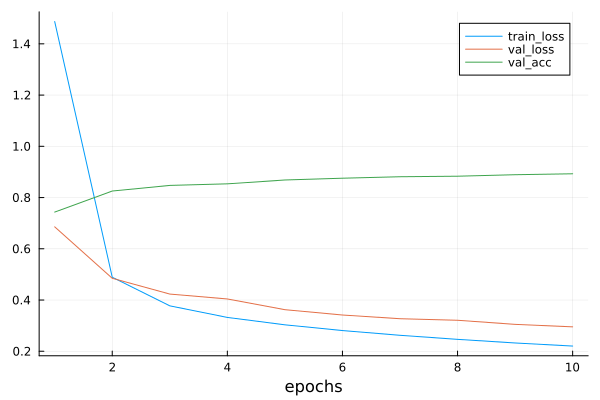

(VGGNet{Chain{Tuple{VGGBlock{Chain{Tuple{Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}}}}, VGGBlock{Chain{Tuple{Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}}}}, VGGBlock{Chain{Tuple{Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}}}}, VGGBlock{Chain{Tuple{Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}}}}, VGGBlock{Chain{Tuple{Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, Conv{2, 4, typeof(relu), Array{Float32, 4}, Vector{Float32}}, MaxPool{2, 4}}}}, typeof(Flux.flatten), Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dropout{Float64, Colon, Random.TaskLocalRNG}, Dense{typeof(relu), Matrix{Float32}, Vector{Float32}}, Dropout{Float64, Colon, Random.TaskLocalRNG}, Dense{typeof(identity), Matrix{Float32}, Vector{Float32}}, typeof

In [26]:
model = VGGNet(((1, 16), (1, 32), (2, 64), (2, 128), (2, 128)))
data = d2lai.FashionMNISTData(batchsize = 128, resize = (224, 224))
opt = Descent(0.01)
trainer = Trainer(model, data, opt; max_epochs = 10, gpu = true, board_yscale = :identity)
d2lai.fit(trainer);


## Summary

One might argue that VGG is the first truly modern convolutional neural network. While AlexNet introduced many of the components of what make deep learning effective at scale, it is VGG that arguably introduced key properties such as blocks of multiple convolutions and a preference for deep and narrow networks. It is also the first network that is actually an entire family of similarly parametrized models, giving the practitioner ample trade-off between complexity and speed. This is also the place where modern deep learning frameworks shine. It is no longer necessary to generate XML configuration files to specify a network but rather, to assemble said networks through simple Python code. 

More recently ParNet :cite:`Goyal.Bochkovskiy.Deng.ea.2021` demonstrated that it is possible to achieve competitive performance using a much more shallow architecture through a large number of parallel computations. This is an exciting development and there is hope that it will influence architecture designs in the future. For the remainder of the chapter, though, we will follow the path of scientific progress over the past decade. 

## Exercises


1. Compared with AlexNet, VGG is much slower in terms of computation, and it also needs more GPU memory. 
    1. Compare the number of parameters needed for AlexNet and VGG.
    1. Compare the number of floating point operations used in the convolutional layers and in the fully connected layers. 
    1. How could you reduce the computational cost created by the fully connected layers?
1. When displaying the dimensions associated with the various layers of the network, we only see the information associated with eight blocks (plus some auxiliary transforms), even though the network has 11 layers. Where did the remaining three layers go?
1. Use Table 1 in the VGG paper :cite:`Simonyan.Zisserman.2014` to construct other common models, such as VGG-16 or VGG-19.
1. Upsampling the resolution in Fashion-MNIST eight-fold from $28 \times 28$ to $224 \times 224$ dimensions is very wasteful. Try modifying the network architecture and resolution conversion, e.g., to 56 or to 84 dimensions for its input instead. Can you do so without reducing the accuracy of the network? Consult the VGG paper :cite:`Simonyan.Zisserman.2014` for ideas on adding more nonlinearities prior to downsampling.

**1**: 
    A: The parameters needed for AlexNet is 46_764_746 and for VGG-11 is 128_806_154, almost thrice to that of an AlexNet 
    C: We can use pooling to downsample more towards the end. 

**2**: Not an issue in Julia. However for Pytorch, the display shows the output of a sequential layer, i.e. collected output for all convolution layers + the pooling layer associated to a block, thats why we see less layers.

**3**: VGG 16 and VGG 19 Respectively:

In [6]:
vgg_16 = VGGNet(((2, 64), (2, 128), (3, 256), (3, 512), (3, 512)))

VGGNet(
  Chain(
    VGGBlock(
      Chain(
        Conv((3, 3), 1 => 64, relu, pad=1),  # 640 parameters
        Conv((3, 3), 64 => 64, relu, pad=1),  # 36_928 parameters
        MaxPool((2, 2)),
      ),
    ),
    VGGBlock(
      Chain(
        Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
        Conv((3, 3), 128 => 128, relu, pad=1),  # 147_584 parameters
        MaxPool((2, 2)),
      ),
    ),
    VGGBlock(
      Chain(
        Conv((3, 3), 128 => 256, relu, pad=1),  # 295_168 parameters
        Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 parameters
        Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 parameters
        MaxPool((2, 2)),
      ),
    ),
    VGGBlock(
      Chain(
        Conv((3, 3), 256 => 512, relu, pad=1),  # 1_180_160 parameters
        Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters
        Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters
        MaxPool((2, 2)),
      ),
    ),
    VGGBlock(
      Chain(


In [7]:
vgg_19 = VGGNet(((2, 64), (2, 128), (4, 256), (4, 512), (4, 512)))

VGGNet(
  Chain(
    VGGBlock(
      Chain(
        Conv((3, 3), 1 => 64, relu, pad=1),  # 640 parameters
        Conv((3, 3), 64 => 64, relu, pad=1),  # 36_928 parameters
        MaxPool((2, 2)),
      ),
    ),
    VGGBlock(
      Chain(
        Conv((3, 3), 64 => 128, relu, pad=1),  # 73_856 parameters
        Conv((3, 3), 128 => 128, relu, pad=1),  # 147_584 parameters
        MaxPool((2, 2)),
      ),
    ),
    VGGBlock(
      Chain(
        Conv((3, 3), 128 => 256, relu, pad=1),  # 295_168 parameters
        Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 parameters
        Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 parameters
        Conv((3, 3), 256 => 256, relu, pad=1),  # 590_080 parameters
        MaxPool((2, 2)),
      ),
    ),
    VGGBlock(
      Chain(
        Conv((3, 3), 256 => 512, relu, pad=1),  # 1_180_160 parameters
        Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters
        Conv((3, 3), 512 => 512, relu, pad=1),  # 2_359_808 parameters

**4**:

In [29]:
struct VGGSmallNet{N} <: AbstractClassifier 
    net::N
end 

function VGGSmallNet(; num_classes = 10)
    net = Flux.@autosize (56, 56, 1, 1) Chain(
        Conv((3,3), 1 => 16, relu, pad = 1),
        MaxPool((2,2), stride = 2),

        Conv((3,3), 16 => 32, relu, pad = 1),
        MaxPool((2,2), stride = 2),

        Conv((3,3), 32 => 64, relu, pad = 1),
        Conv((1,1), 64 => 64, relu),
        MaxPool((2,2), stride = 1),

        Conv((3,3), 64 => 128, relu, pad = 1),
        Conv((1,1), 128 => 128, relu),
        MaxPool((2,2), stride = 2),

        
        Flux.flatten,
        Dense(_ => 4096, relu),
        Dropout(0.5),
        Dense(4096, 4096, relu),
        Dropout(0.5),
        Dense(4096, num_classes),
        softmax
        
        
    )
    VGGSmallNet(net)
end
Flux.@layer VGGSmallNet 
(v::VGGSmallNet)(x) = v.net(x)


[ Info: Train Loss: 0.95945525, Val Loss: 0.5622649, Val Acc: 0.8125
[ Info: Train Loss: 0.56179816, Val Loss: 0.40773425, Val Acc: 0.875
[ Info: Train Loss: 0.5326469, Val Loss: 0.33665746, Val Acc: 0.8125
[ Info: Train Loss: 0.47002974, Val Loss: 0.24386045, Val Acc: 0.875
[ Info: Train Loss: 0.34498596, Val Loss: 0.2215715, Val Acc: 0.9375
[ Info: Train Loss: 0.51154643, Val Loss: 0.28165364, Val Acc: 0.875
[ Info: Train Loss: 0.25447252, Val Loss: 0.24042852, Val Acc: 0.875
[ Info: Train Loss: 0.40097007, Val Loss: 0.17593385, Val Acc: 0.9375
[ Info: Train Loss: 0.22108968, Val Loss: 0.22856621, Val Acc: 0.875
[ Info: Train Loss: 0.20709628, Val Loss: 0.19818446, Val Acc: 0.875


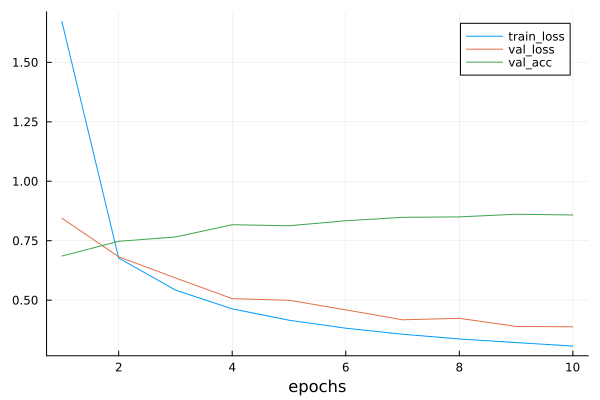

In [30]:
data_downsampled = d2lai.FashionMNISTData(batchsize = 128, resize = (56, 56))
model_small = VGGSmallNet()
opt = Descent(0.01)
trainer_small = Trainer(model_small, data_downsampled, opt; max_epochs = 10, gpu = true, board_yscale = :identity)
d2lai.fit(trainer_small);